### Supervised Learning: A Simple Linear Regression Example
Supervised Learning is a core concept in Machine Learning. It means we learn from labeled data—pairs of inputs and outputs—so that the model can predict outputs for new inputs.

#### What is the Goal?
We observe pairs $(x_1, y_1)$, $(x_2, y_2)$, $\dots$, $(x_n, y_n)$ and want to learn a function $f(x)$ such that:

$$
\hat{y} = f(x)
$$

For a linear model:

$$
\hat{y} = \beta_0 + \beta_1 x
$$

The goal is to choose coefficients $\beta_0$ and $\beta_1$ that minimize the total prediction error:

$$
\sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

This is the **Least Squares** method.

Why is this important?
- This is the foundation of many ML algorithms.
- It shows how models learn patterns from data.
- It introduces loss functions and optimization, key ideas in ML.

Below, we illustrate how the algorithm learns these coefficients.

**Step 1: Generate Data**

We’ll create synthetic data to simulate a real-world scenario.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate random x values
x = np.linspace(0, 10, 50)

# True relationship: y = 3 + 2x + noise
y_true = 3 + 2 * x
noise = np.random.normal(0, 4, size=x.shape)
y = y_true + noise

**Step 2: Learn the Model (Manual Least Squares)**

- Compute $\beta_0$​ and $\beta_1$:

In [2]:
# Compute regression coefficients manually
x_mean = np.mean(x)
y_mean = np.mean(y)

beta_1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
beta_0 = y_mean - beta_1 * x_mean

print(f"Least Squares Coefficients: beta_0 = {beta_0:.2f}, beta_1 = {beta_1:.2f}")

Least Squares Coefficients: beta_0 = 3.26, beta_1 = 1.77


**Step 3: Make Predictions**

In [3]:
# Predicted values
y_pred = beta_0 + beta_1 * x

**Step 3: Evaluate the Model**
- Compute $\text{R}^2$ and $\text{RMSE}$:

In [4]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R² = {r2:.3f}, RMSE = {rmse:.3f}")

R² = 0.673, RMSE = 3.633


**Step 5: Visualize Predictions vs Observations**

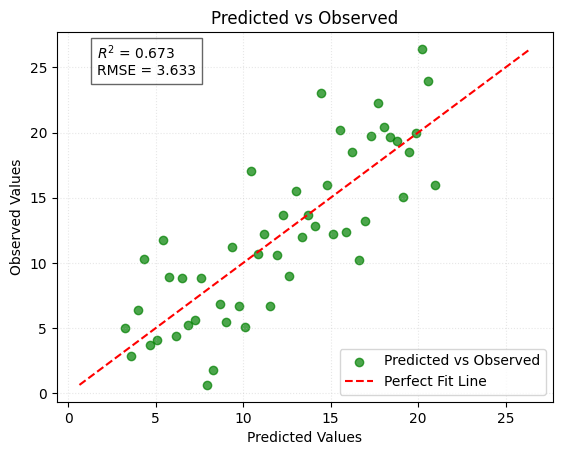

In [5]:
# Plot predicted vs observed
plt.scatter(y_pred, y, color='green', alpha=0.7, label='Predicted vs Observed')

# Perfect fit line
min_val = min(min(y_pred), min(y))
max_val = max(max(y_pred), max(y))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Fit Line')

# Annotate metrics
plt.text(min_val + 1, max_val - 2, f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.3f}",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.title('Predicted vs Observed')
plt.legend(loc = 'lower right')
plt.grid(alpha=0.3, linestyle = ':')
plt.show()

The red line is the model's prediction. It learned $\beta_0$ and $\beta_1$ by minimizing the squared errors.

We can use **scikit-learn** to do the same and compare results.

In [6]:
from sklearn.linear_model import LinearRegression

# Reshape x for sklearn
X = x.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

print(f"sklearn coefficients: beta_0 = {model.intercept_:.2f}, beta_1 = {model.coef_[0]:.2f}")

sklearn coefficients: beta_0 = 3.26, beta_1 = 1.77


**Food for Thought:**
- What happens if we increase noise?
- What if the true relationship is non-linear?
- How would this change if we used multiple features?
- Why do we call this Supervised Learning?
- Can you think of real-world examples where this approach is useful?

### Real-Time Streamflow Forecasting with Machine Learning
In the previous section, we learned the basics of Supervised Learning using synthetic data.
Now, let’s apply the same principles to real hydrologic data: **streamflow from a USGS gauge.**

***

#### Why This Matters

*   Hydrologic forecasting is critical for **water resources management**, **flood prediction**, and **ecological planning**.
*   Machine Learning can help extract patterns from historical data to predict future values.
*   We’ll start simple: **predict tomorrow’s streamflow using the past 7 days**.

***

##### Step 1: Retrieve Real Streamflow Data

We use the **USGS Water Data API** via the `dataretrieval` Python package.

#### API Token
To access USGS water data services, you can obtain an API key. The system enforces hourly request limits per IP address. If you frequently hit these limits, consider requesting an API token [here](https://api.waterdata.usgs.gov/signup/) to increase your allowed number of queries.

In [7]:
# pip install dataretrieval
# pip install git+https://github.com/DOI-USGS/dataretrieval-python.git
# import os
# os.environ["API_USGS_PAT"] = "API"

import dataretrieval.waterdata as waterdata

# Get daily streamflow data (returns DataFrame and metadata)
df, metadata = waterdata.get_daily(
    monitoring_location_id='USGS-02414715', #Tallapoosa River NR New Site, Al.(horseshoe Bend) 
    parameter_code='00060',  # Discharge
    time='2020-10-01/2025-11-25'
)

print(f"Retrieved {len(df)} records")
print(f"Site: {df['monitoring_location_id'].iloc[0]}")
print(f"Mean discharge: {df['value'].mean():.2f} {df['unit_of_measure'].iloc[0]}")

Retrieved 1882 records
Site: USGS-02414715
Mean discharge: 2804.89 ft^3/s


***
##### Step 2: Clean and Inspect Data

In [8]:
import pandas as pd
import geopandas as gpd

# Convert to GeoDataFrame if needed
if not isinstance(df, gpd.GeoDataFrame):
    df = gpd.GeoDataFrame(df, geometry="geometry")

# Extract coordinates
lon = df.geometry.x
lat = df.geometry.y

# Keep essential columns
df_clean = df[["time", "value", "unit_of_measure", "approval_status"]].copy()
df_clean["time"] = pd.to_datetime(df_clean["time"])
df_clean = df_clean.sort_values("time").reset_index(drop=True)
print("Missing values:", df_clean.isna().sum())

# Quick check
df_clean.head()

Missing values: time               0
value              0
unit_of_measure    0
approval_status    0
dtype: int64


,time,value,unit_of_measure,approval_status
0,2020-10-01,2480,ft^3/s,Approved
1,2020-10-02,937,ft^3/s,Approved
2,2020-10-03,1450,ft^3/s,Approved
3,2020-10-04,1440,ft^3/s,Approved
4,2020-10-05,1210,ft^3/s,Approved


***

##### Step 3: Visualize the Time Series

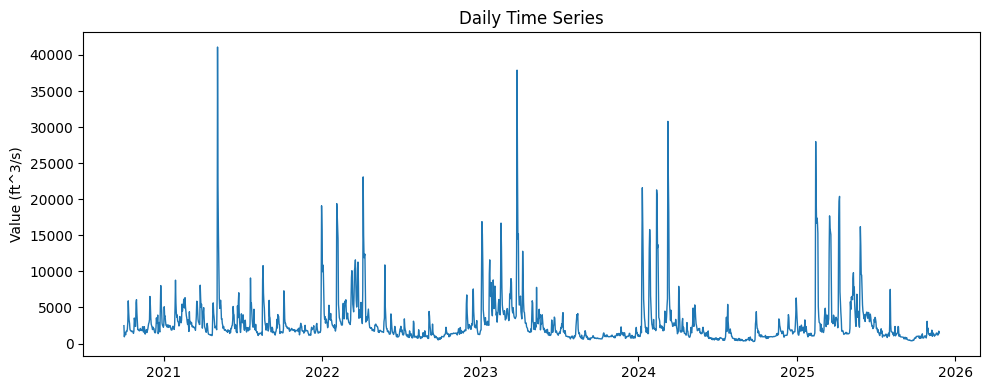

In [9]:
# Simple visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_clean["time"], df_clean["value"], linewidth=1)
plt.ylabel(f"Value ({df_clean['unit_of_measure'].iloc[0]})")
plt.title("Daily Time Series")
plt.tight_layout()
plt.show()

#### Forecasting Streamflow Using Simple Machine Learning Models

We have seen how to do predictions us9ing a simple linear model but just using randomly generated data. Now, we are going to use stream discharge and develop a simple model. 

Forecasting hydrologic time series does not always require complex deep learning models.
Even simple statistical models can extract meaningful temporal structure when provided with a clean and supervised dataset.

Now we shall see:

- Linear Regression (baseline)
- MLP Neural Network (a simple nonlinear extension)

Both models predict tomorrow’s streamflow using the previous 7 days.

We then evaluate how forecast accuracy degrades as the forecast horizon increases from 1 to 7 days.

Finally, we produce a full time-series plot comparing observed vs predicted streamflow for both models.

##### Step 1: Convert the Time Series Into a Supervised Learning Dataset

Most machine-learning models require an input/output structure.

Here, each training sample uses the previous 7 days to predict the next day.

***
#### From Time Series to Supervised Learning

We need to **convert the sequence into input/output pairs**:

*   **Input (X)**: Previous 7 days of streamflow.
*   **Output (y)**: Streamflow for the next day.

In [10]:
values = df_clean["value"].values

def build_supervised(series, window=7):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

window = 7
X, y = build_supervised(values, window=window)

***
##### Step 4: Train a Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

# Predict for all windows
y_pred = model.predict(X)

from sklearn.metrics import r2_score, mean_squared_error
print(f"In-sample 1-day-ahead R^2:", r2_score(y, y_pred))

In-sample 1-day-ahead R^2: 0.6206006037977907


***
##### Step 5: Multi-Step Forecast Skill (1–7 Days Ahead)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

max_horizon = 7
horizons, r2_scores, rmse_scores = [], [], []

for h in range(1, max_horizon + 1):
    preds, trues = [], []
    for i in range(0, len(values) - window - h + 1):
        seq = values[i : i + window].copy()
        for step in range(h):
            next_val = model.predict(seq.reshape(1, -1))[0]
            seq = np.append(seq[1:], next_val)
        preds.append(next_val)
        trues.append(values[i + window + h - 1])

    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    horizons.append(h)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

print("R^2 by horizon:", r2_scores)
print("RMSE by horizon:", rmse_scores)

R^2 by horizon: [0.6206006037977906, 0.31742680555909475, 0.1697419993428665, 0.09212576007578188, 0.05891687900451992, 0.042315505460492675, 0.03763188410046325]
RMSE by horizon: [2021.5891408236787, 2712.195969289035, 2992.009701468704, 3129.571870655367, 3186.383580421272, 3215.0478903259145, 3223.7478611962233]


***
##### Step 6: Plot Accuracy vs Horizon

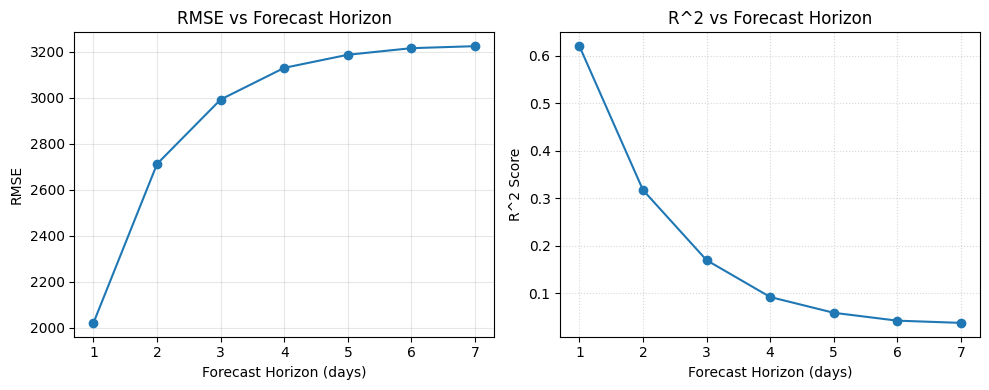

In [13]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(horizons, rmse_scores, marker="o")
plt.title("RMSE vs Forecast Horizon")
plt.xlabel("Forecast Horizon (days)")
plt.ylabel("RMSE")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(horizons, r2_scores, marker="o")
plt.title("R^2 vs Forecast Horizon")
plt.xlabel("Forecast Horizon (days)")
plt.ylabel("R^2 Score")
plt.grid(alpha=0.5, linestyle = ':')

plt.tight_layout()
plt.show()

***
##### Step 7: Add a Neural Network Model (MLP)

In [14]:
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)

nn_model.fit(X, y)
y_pred_nn = nn_model.predict(X)
print("NN 1-day R^2:", r2_score(y, y_pred_nn))

NN 1-day R^2: 0.6760723717663428


#### Full Time-Series Plot: Observed vs Predicted
This shows the full data period and illustrates how predictions track the observations.

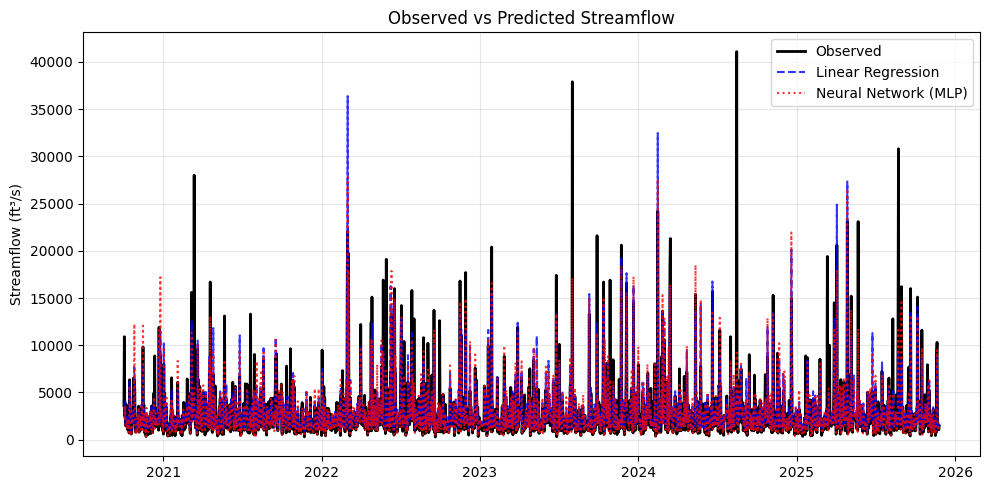

In [15]:
# Build aligned dataframe
time_pred = df["time"].iloc[window:].reset_index(drop=True)

plot_df = pd.DataFrame({
    "time": time_pred,
    "observed": y,
    "linear_pred": y_pred,
    "nn_pred": y_pred_nn
}).sort_values("time").reset_index(drop=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(plot_df["time"], plot_df["observed"], color = 'k', label="Observed", linewidth=2)
plt.plot(plot_df["time"], plot_df["linear_pred"], color = 'b', linestyle = '--',
         label="Linear Regression", alpha=0.8)
plt.plot(plot_df["time"], plot_df["nn_pred"], color = 'r', linestyle = ':',
         label="Neural Network (MLP)", alpha=0.8)

plt.ylabel("Streamflow (ft³/s)")
plt.title("Observed vs Predicted Streamflow")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Zoom Into the Last Two Months

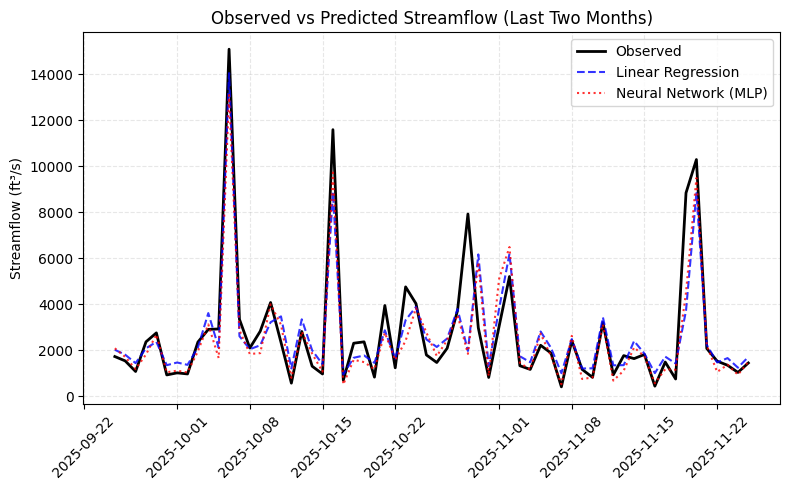

In [16]:
# Ensure time column is proper datetime
plot_df["time"] = pd.to_datetime(plot_df["time"])

# Filter for the last two months
last_time = pd.to_datetime(plot_df["time"].max())
two_months_ago = last_time - pd.DateOffset(months=2)

# Guarantee timestamp type
two_months_ago = pd.Timestamp(two_months_ago)

# Filter
zoom_df = plot_df[plot_df["time"] >= two_months_ago]

# Plot zoomed view
plt.figure(figsize=(8,5))
plt.plot(zoom_df["time"], zoom_df["observed"], color = 'k', linestyle = '-',
         label="Observed", linewidth=2)
plt.plot(zoom_df["time"], zoom_df["linear_pred"], color = 'b', linestyle = '--',
         label="Linear Regression", alpha=0.8)
plt.plot(zoom_df["time"], zoom_df["nn_pred"], color = 'r', linestyle = ':',
         label="Neural Network (MLP)", alpha=0.8)

plt.ylabel("Streamflow (ft³/s)")
plt.title("Observed vs Predicted Streamflow (Last Two Months)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3, linestyle = '--')
plt.tight_layout()
plt.show()

***
### Summary

- A simple 7-day autoregressive Linear Regression already captures meaningful structure.
- Accuracy decreases with forecast horizon, as expected in hydrologic systems.
- A simple MLP neural network offers a small nonlinear improvement but still relies on the same 7-day memory window.
- This tutorial shows how even simple models can be used for short-term flow forecasting and model comparison.

***
#### Key Takeaways

*   **Linear Regression** provides a simple baseline.
*   **Neural Networks** can capture nonlinear patterns and improve short-term accuracy.
*   Forecast skill **degrades with horizon**—a fundamental challenge in hydrology.
*   This is **Supervised Learning in action**: learning from past data to predict the future.

***
#### Food for Thought:
1.  What happens if we use **more than 7 days** as input?
2.  How would **seasonality** affect predictions?
3.  Why does uncertainty grow with forecast horizon?
4.  Can we integrate **weather forecasts** to improve predictions?
***

### Extra: Same data but worked using LSTM.

2025-12-01 09:16:59.896916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-01 09:16:59.896963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-01 09:16:59.898717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-01 09:16:59.907874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 09:17:01.544104: W tensorflow/comp

59/59 [==============================] - 0s 1ms/step

LSTM R² = 0.661



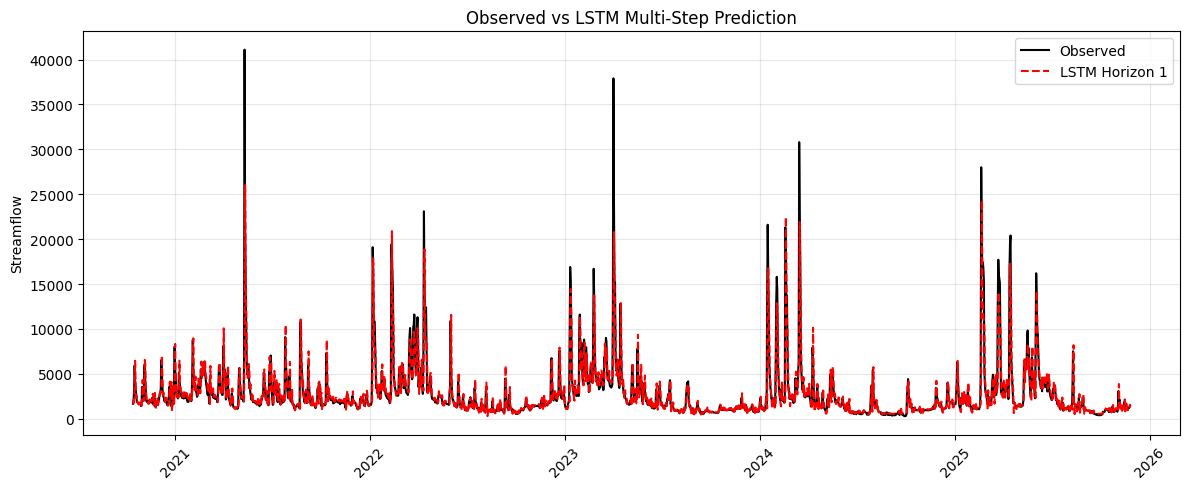

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Prepare data
df = df_clean.copy()
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").reset_index(drop=True)

values = df["value"].values.astype(float)

# Scale
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Parameters
window = 7
max_horizon = 7

# Build supervised sequences for multi-step
X, y = [], []
for i in range(len(values_scaled) - window - max_horizon + 1):
    seq_x = values_scaled[i : i + window]
    seq_y = values_scaled[i + window : i + window + max_horizon]
    X.append(seq_x)
    y.append(seq_y)

X = np.array(X).reshape(-1, window, 1)
y = np.array(y)  # shape: (samples, max_horizon)

# Define and train multi-step LSTM
lstm_model = Sequential([
    LSTM(16, activation='tanh', input_shape=(window, 1)),
    Dense(8, activation='relu'),
    Dense(max_horizon)  # multi-step output
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X, y, epochs=100, batch_size=16, verbose=0)

# Predict and inverse-transform
y_pred_scaled = lstm_model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled)
obs = scaler.inverse_transform(y)

# Compute R²
r2_lstm = r2_score(obs[:, 0], y_pred[:, 0])
print(f"\nLSTM R² = {r2_lstm:.3f}\n")

# Plot example for first horizon
plt.figure(figsize=(12, 5))
plt.plot(df["time"].iloc[window+max_horizon-1:], obs[:, 0], color='k', label="Observed")
plt.plot(df["time"].iloc[window+max_horizon-1:], y_pred[:, 0], color='r', linestyle='--', label="LSTM Horizon 1")
plt.ylabel("Streamflow")
plt.title("Observed vs LSTM Multi-Step Prediction")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

***
##### Compare Forecast Skill

In [18]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Fast LSTM wrapper for multi-step output
class FastLSTMWrapper:
    def __init__(self, lstm_model, scaler, window, max_horizon):
        self.model = lstm_model
        self.scaler = scaler
        self.window = window
        self.max_horizon = max_horizon

    def preprocess_series(self, raw_values):
        """Scale entire evaluation set once."""
        scaled = self.scaler.transform(raw_values.reshape(-1, 1)).flatten()
        return scaled

    def predict_multi(self, seq_scaled):
        """
        seq_scaled: 1D array of length `window` in SCALED units.
        Returns array of raw predictions for all horizons.
        """
        inp = seq_scaled.reshape(1, self.window, 1)
        pred_scaled = self.model.predict(inp, verbose=0)[0]  # shape: (max_horizon,)
        pred_raw = self.scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
        return pred_raw

def multistep_skill(model, values, window=7, max_horizon=7, is_lstm=False):
    results = []
    N = len(values)

    # For LSTM, scale once if wrapper provided
    if is_lstm:
        values_scaled = model.preprocess_series(values)
        limit = N - window - max_horizon + 1
        preds = [[] for _ in range(max_horizon)]
        trues = [[] for _ in range(max_horizon)]

        for i in range(limit):
            seq_scaled = values_scaled[i : i + window]
            pred_raw = model.predict_multi(seq_scaled)  # all horizons at once
            for h in range(max_horizon):
                preds[h].append(pred_raw[h])
                trues[h].append(values[i + window + h])

        # Compute metrics per horizon
        for h in range(max_horizon):
            r2 = r2_score(trues[h], preds[h])
            rmse = np.sqrt(mean_squared_error(trues[h], preds[h]))
            results.append((h + 1, r2, rmse))

    else:
        # For linear/MLP (single-step models)
        for h in range(1, max_horizon + 1):
            preds, trues = [], []
            for i in range(N - window - h + 1):
                seq = values[i : i + window].copy()
                # autoregressive forecasting
                for step in range(h):
                    next_val = model.predict(seq.reshape(1, -1))[0]
                    seq = np.append(seq[1:], next_val)
                preds.append(next_val)
                trues.append(values[i + window + h - 1])

            r2 = r2_score(trues, preds)
            rmse = np.sqrt(mean_squared_error(trues, preds))
            results.append((h, r2, rmse))

    return results

In [20]:
# Instantiate wrapper
lstm_wrapper = FastLSTMWrapper(lstm_model, scaler, window, max_horizon)

lin_results  = multistep_skill(model, values, window=7, max_horizon=7, is_lstm=False)
nn_results   = multistep_skill(nn_model, values, window=7, max_horizon=7, is_lstm=False)
lstm_results = multistep_skill(lstm_wrapper, values, window=7, max_horizon=7, is_lstm=True)

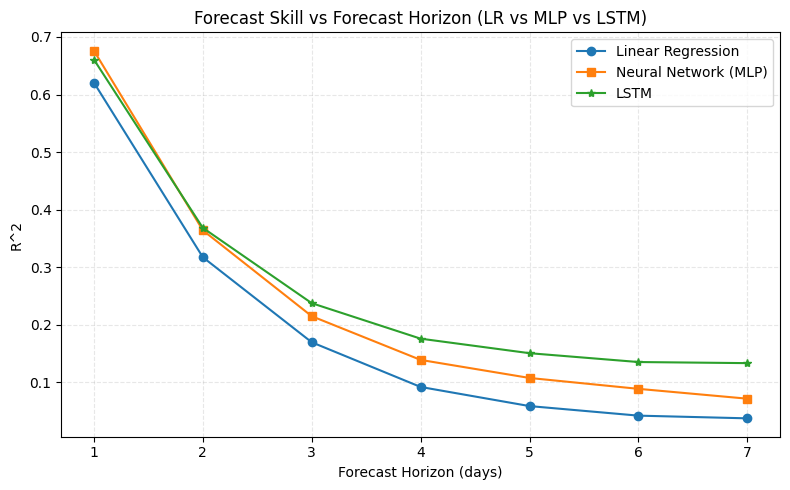

In [21]:
h_lin  = [r[0] for r in lin_results]
r2_lin = [r[1] for r in lin_results]

h_nn  = [r[0] for r in nn_results]
r2_nn = [r[1] for r in nn_results]

h_lstm  = [r[0] for r in lstm_results]
r2_lstm = [r[1] for r in lstm_results]


# Plot Comparison: LR vs MLP vs LSTM
plt.figure(figsize=(8,5))

plt.plot(h_lin,  r2_lin,  marker="o", label="Linear Regression")
plt.plot(h_nn,   r2_nn,   marker="s", label="Neural Network (MLP)")
plt.plot(h_lstm, r2_lstm, marker="*", label="LSTM")

plt.xlabel("Forecast Horizon (days)")
plt.ylabel("R^2")
plt.title("Forecast Skill vs Forecast Horizon (LR vs MLP vs LSTM)")
plt.legend()
plt.grid(alpha=0.3, linestyle = '--')
plt.tight_layout()
plt.show()